In [1]:
# LAMBDA PYTHON IMPORT
import os
import sys
sys.path.insert(0, os.path.abspath('./code/'))

# PYSPARK IMPORT
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# CUSTOM IMPORT
import entryPoint

In [2]:
# IMPORT DATASET
path = "./data/subventions-accordees-et-refusees.csv"
df = spark.read.format('csv').options(header=True, inferSchema=True, sep =';').load(path)

newColumns = ['Num', 'Annee', 'Collectivite', 'Benificiaire', 'Siret', 'Objet', 'Montant', 'Direction', 'Nature', 'Secteur']
df = df.toDF(*newColumns)

In [3]:
# Récupération des secteurs

secteurs = entryPoint.getAllSecteur(df)

for secteur in secteurs:
    print(secteur)

Aides aux associations
Architecture & urbanisme
Communication & média
Culture & Arts
Défense des droits et des intérêts
Déplacements et transports
Economie
Education & formation
Emploi
Environnement & écologie
Humanitaire
Idée & opinion
Loisirs
Mémoire
Précarité & Exclusion
Relations internationales
Santé
Social
Sport
Technique & Recherche
Tourisme
Vie et animation locale


In [4]:
# Récupérer uniquement un `Secteur` spécifique

entryPoint.selectSecteur(df, 'Vie et animation locale').take(10)

[Row(Num='2019_05884', Annee=2019, Collectivite='Ville de Paris', Benificiaire='129 H PRODUCTIONS', Siret='44326922000036', Objet='Le Grand Slam des Amandiers', Montant='2500', Direction='DAC', Nature='Projet', Secteur='Culture & Arts;Education & formation;Vie et animation locale'),
 Row(Num='2019_06441', Annee=2019, Collectivite='Ville de Paris', Benificiaire='13 POUR TOUS', Siret='48905531900029', Objet='Pause toi là', Montant='3000', Direction='DJS', Nature='Projet', Secteur='Loisirs;Social;Vie et animation locale'),
 Row(Num='2019_02145', Annee=2019, Collectivite='Ville de Paris', Benificiaire='3 S : SEJOUR SPORTIF SOLIDAIRE', Siret='81147565600013', Objet='Transport, voirie, déplacements et espace public', Montant='0', Direction='DVD', Nature='Non précisée', Secteur='Environnement & écologie;Sport;Vie et animation locale'),
 Row(Num='2019_07417', Annee=2019, Collectivite='Ville de Paris', Benificiaire="ACCUEIL GOUTTE D'OR", Siret='40864600800057', Objet="Atelier Parents d'enfants 

Renseignez votre année : (2013 - 2020)2020


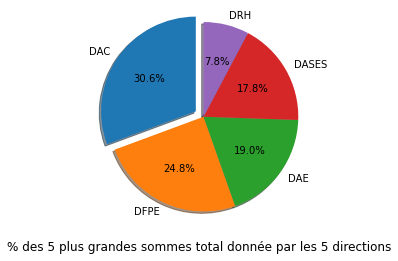

In [5]:
# Permet d'obtenir le montant total des 5 directions qui subventionnent le plus les associations.

entryPoint.getAmountSubventionByDirection(df)

Renseignez votre année : (2013 - 2020)2020


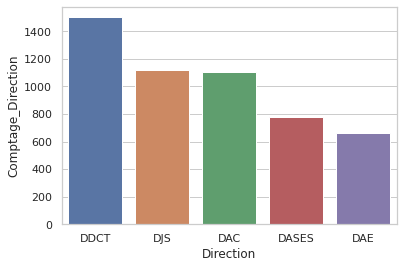

In [6]:
#Permet d'obtenir le nombre total de subvention accordées par les directions.

entryPoint.getCountAcceptedSubventionByDirection(df)